In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler

Predict the next data using the 3 previous data:

X1	 X2	 X3	 Y

112	118	132	129

118	132	129	121

data format:
x -> y = [93,1,3] -> [93,1]

x = [
    [[x1,x2,x3]], 
    [[x1,x2,x3]], 
     ...]

y = [
    [y1],
    [y2],
     ...]
   
input_shape=(1,3)

You can change the parameter to change the prediction step:
look_back = 3

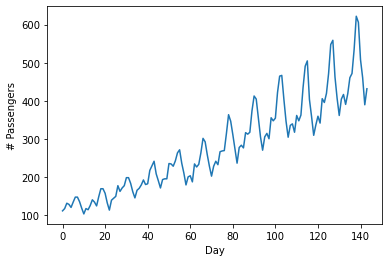

In [76]:
# load the dataset
dataframe = pd.read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
plt.plot(dataset)
plt.xlabel('Day')
plt.ylabel('# Passengers')
plt.show()

In [77]:
# Define LSTM Neural Networks
class LSTM(nn.Module):
    """
        Parameters：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
 
    def __init__(self, input_size, hidden_size=1, output_size=1, num_layers=1):
        super().__init__()
 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)  # utilize the LSTM model in torch.nn
        self.linear1 = nn.Linear(hidden_size, output_size) # full connection
 
    def forward(self, _x):
        x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape     # x is output, size (seq_len, batch, hidden_size)
        x = x.view(s * b, h)  # size (seq_len * batch, hidden_size)
        x = self.linear1(x)   # size (seq_len * batch, output_size)
        x = x.view(s, b, -1)  # size (seq_len, batch, output_size)
        return x

In [78]:
# Generate the dataset format
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [79]:
#Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Split dataset into training and test (2 : 1)
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train_data, test_data = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# prediction step = 3
# create dataset for training and testing
look_back = 3
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

# Reshape: [samples, batch, input_features] = [93,1,3]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# Reshape: [samples, batch, output_features] = [93,1,1]
trainY = np.reshape(trainY, (trainY.shape[0], 1, 1))
testY = np.reshape(testY, (testY.shape[0], 1, 1))

# Check device: GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ', device)

# float to tensor
trainX = torch.from_numpy(trainX).to(device)
trainY = torch.from_numpy(trainY).to(device)
testX = torch.from_numpy(testX).to(device)

print('The shape of X:', trainX.shape)
print('The shape of Y:', trainY.shape)

device:  cpu
The shape of X: torch.Size([93, 1, 3])
The shape of Y: torch.Size([93, 1, 1])


In [80]:
# define the model
model = LSTM(input_size=3, hidden_size=4, output_size=1, num_layers=1)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [81]:
# train the model
epoches = 500
for epoch in range(epoches):
    output = model(trainX)
    loss = criterion(output,trainY)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 100 == 0:
        print('{} / {}, loss: {}'.format(epoch+1, epoches, loss))

100 / 500, loss: 0.004196250811219215
200 / 500, loss: 0.0032683894969522953
300 / 500, loss: 0.0024265828542411327
400 / 500, loss: 0.001556705916300416
500 / 500, loss: 0.0013835250865668058


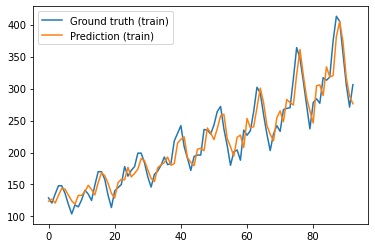

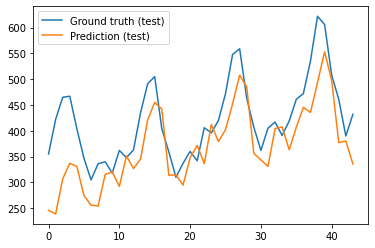

In [82]:
# Show the results
# train
trainPre = model(trainX).data.cpu().numpy()
trainY = trainY.data.cpu().numpy()
# test
testPre = model(testX).data.cpu().numpy()

# Denormalization
trainPre = scaler.inverse_transform(trainPre[:,:,0])
trainY = scaler.inverse_transform(trainY[:,:,0])
testPre = scaler.inverse_transform(testPre[:,:,0])
testY = scaler.inverse_transform(testY[:,:,0])
# Plot the results
plt.plot(trainY, label = 'Ground truth (train)')
plt.plot(trainPre, label = 'Prediction (train)')
plt.legend()
plt.show()
plt.close('all')
plt.plot(testY, label = 'Ground truth (test)')
plt.plot(testPre, label = 'Prediction (test)')
plt.legend()
plt.show()